![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Análise Exploratória de Dados: Casos Internacionais e Intervenções

Neste *notebook* analisamos os casos reportados ao redor do mundo, bem como as medidas de mitigação tomadas por diversos governos, com base em dados disponíveis publicamente.

**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Parâmetros da Análise

Algumas configurações gerais para guiar nossa análise.

### Ordenação

Qual métrica deve ser utilizada para ordenar os casos selecionados?

In [4]:
order_by = 'total_cases'
#order_by = 'total_cases_per_capita'

### Filtros

Quantos casos iniciais exigimos para considerarmos a data como *data inicial* (d0) da epidemia em cada localidade? Um número substancial de casos mínimos ajuda a estabelecer uma data em que a epidemia está efetivamente instalada, com menor risco de ser um erro ou flutuação controlável.

In [5]:
min_cases_for_initial_date = 50 # 1

Qual o número mínimo de casos (fatais ou não) registrados em um dado país para que seja considerado na análise?

In [6]:
min_cases = 3000

Qual o número mínimo de óbitos registrados em um dado país para que seja considerado na análise?

In [7]:
min_deaths = 200

Além dos critérios numéricos acima, podemos adicionalmente escolher alguns países específicos para estudar.

In [8]:
predefined_selected_locations = [] # ['China', 'Brazil', 'South Korea']

Além de todos os critérios acima, podemos opcionalmente selecionar um número máximo de países para exibir, ordenado pelo total de casos.

In [9]:
max_locations_to_show = 6 #None

Finalmente, podemos forçar a presença adicional de algum(ns) país(es) específico(s), independentemente dos outros filtros, por exemplo do Brasil.

In [10]:
predefined_mandatory_locations = ['Brazil', 'South Korea']

### Outros Parâmeteros

Onde devemos salvar os resultados?

In [11]:
results_folder = '../results/eda/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [12]:
results_suffix = ''

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [13]:
# custom papermill parameters

## Funções Auxiliares
E uma função para auxiliar no desenho de gráficos. Essa função também salva as imagens e dados subjascentes em arquivos se desejado.

In [14]:
def plot_lines(df, title, zoom_range=(None, None), file_path_base=results_folder, file_name=None, ordered_by=order_by, **kwargs):
    
    plt.figure()
    
    if file_name is not None:
        file_name = f'{file_name}_ordered_by_{ordered_by}'
    
    # apply zoom if requested
    if zoom_range[0] is not None or zoom_range[1] is not None:
        title = f'{title} (zoom)'
        df = df.iloc[zoom_range[0]:zoom_range[1]]
        
        if file_name is not None:
            file_name = f'{file_name}_zoom'
    
    # plot
    palette = sns.color_palette("bright", len(df.columns))
    ax = sns.lineplot(data=df, palette=palette, **kwargs)
    ax.set_title(title)
    
    # save result if requested
    if file_name is not None:
        ax.figure.savefig(file_path_base + file_name + results_suffix + '.png', format='png')
        df.to_csv(file_path_base + file_name + results_suffix + '.csv')
        

## Leitura e Preparação de Dados

Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ).

In [15]:
df_epidemy_data = pd.read_csv('../data/ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_epidemy_data.describe()

,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths
count,34742.000000,34742.000000,3.474200e+04,34742.000000,3.396000e+04,33960.000000,3.248300e+04,32483.000000
mean,1081.890622,40.741178,5.666360e+04,2843.699010,7.441900e+03,284.404122,1.478081e+04,577.333097
std,10019.135847,352.496855,5.798296e+05,26895.958906,6.831771e+04,2393.211435,1.336575e+05,4790.973829
min,-2461.000000,-1918.000000,0.000000e+00,0.000000,-2.372000e+03,-1625.000000,-1.490000e+02,-1616.000000
25%,0.000000,0.000000,2.400000e+01,0.000000,2.000000e+00,0.000000,6.000000e+00,0.000000
50%,6.000000,0.000000,5.090000e+02,10.000000,6.600000e+01,1.000000,1.530000e+02,2.000000
75%,112.000000,2.000000,5.914750e+03,117.000000,7.990000e+02,16.000000,1.688000e+03,34.000000
max,298082.000000,10504.000000,1.879352e+07,707715.000000,1.819572e+06,52256.000000,3.598989e+06,97241.000000


In [16]:
df_epidemy_data.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths
0,2019-12-31,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2020-01-01,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2020-01-02,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2020-01-03,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2020-01-04,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [17]:
df_locations_data = pd.read_csv('../data/ourworldindata.org/coronavirus-source-data/locations.csv')
df_locations_data.head()

,countriesAndTerritories,location,continent,population_year,population
0,Afghanistan,Afghanistan,Asia,2020.0,38928341.0
1,Albania,Albania,Europe,2020.0,2877800.0
2,Algeria,Algeria,Africa,2020.0,43851043.0
3,Andorra,Andorra,Europe,2020.0,77265.0
4,Angola,Angola,Africa,2020.0,32866268.0


Vamos enriquecer os dados com informações adicionais sobre as localidades.

In [18]:
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')

df_epidemy_data['total_cases_per_capita'] = df_epidemy_data['total_cases'] / df_epidemy_data['population']
df_epidemy_data['total_deaths_per_capita'] = df_epidemy_data['total_deaths'] / df_epidemy_data['population']

df_epidemy_data.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths,countriesAndTerritories,continent,population_year,population,total_cases_per_capita,total_deaths_per_capita
0,2019-12-31,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Afghanistan,Asia,2020.0,38928341.0,0.0,0.0
1,2020-01-01,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Afghanistan,Asia,2020.0,38928341.0,0.0,0.0
2,2020-01-02,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Afghanistan,Asia,2020.0,38928341.0,0.0,0.0
3,2020-01-03,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Afghanistan,Asia,2020.0,38928341.0,0.0,0.0
4,2020-01-04,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Afghanistan,Asia,2020.0,38928341.0,0.0,0.0


Faixa de datas para a qual temos dados.

In [19]:
print(f"From {df_epidemy_data['date'].iloc[0].date()} to {df_epidemy_data['date'].iloc[-1].date()}")

From 2019-12-31 to 2020-08-06


Quantos países temos representados nos dados epidêmicos?

In [20]:
locations = df_epidemy_data['location'].unique()
len(locations)

210

E quantos países possuem dados adicionais?

In [21]:
df_locations_data['location'].nunique()

210

### Escolha dos Países

Vamos selecionar os países que já tiveram um mínimo de dados reportados, de modo que possamos focar nossa atenção nas localidades com mais informação.

In [22]:
df_epidemy_data_filtered = df_epidemy_data

Vamos retirar a estimativa global, posto que nosso foco é em países individuais.


In [23]:
df_epidemy_data_filtered = df_epidemy_data_filtered[df_epidemy_data_filtered['location'] != 'World']

Filtragem por número mínimo de casos e óbitos.

In [24]:
df_epidemy_data_filtered = df_epidemy_data_filtered[(df_epidemy_data_filtered['total_deaths'] >= min_deaths) & \
                                                    (df_epidemy_data_filtered['total_cases'] >= min_cases)]

locations_filtered = df_epidemy_data_filtered['location'].unique()

# filtering must occur after the locations have been selected, otherwise we may lose data points when the
# location was still in early epidemic stages.
df_epidemy_data_filtered = df_epidemy_data[df_epidemy_data['location'].isin(locations_filtered)]
df_epidemy_data_filtered.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths,countriesAndTerritories,continent,population_year,population,total_cases_per_capita,total_deaths_per_capita
0,2019-12-31,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Afghanistan,Asia,2020.0,38928341.0,0.0,0.0
1,2020-01-01,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Afghanistan,Asia,2020.0,38928341.0,0.0,0.0
2,2020-01-02,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Afghanistan,Asia,2020.0,38928341.0,0.0,0.0
3,2020-01-03,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Afghanistan,Asia,2020.0,38928341.0,0.0,0.0
4,2020-01-04,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Afghanistan,Asia,2020.0,38928341.0,0.0,0.0


Caso se deseje filtrar adicionalmente por alguns países específicos, isso ocorre aqui.

In [25]:
if len(predefined_selected_locations) > 0:
    df_epidemy_data_filtered = df_epidemy_data_filtered[df_epidemy_data_filtered['location'].isin(predefined_selected_locations)]

Se quisermos limitar a quantidade total de países sendo analisados, isso é feito agora. Primeiramente, tomemos os maiores números em cada métrica e ordenemos do maior para o menor (de acordo com o número total de casos per capita).

In [26]:
df_max_values_ordered = df_epidemy_data_filtered \
                            .groupby('location') \
                            .max() \
                            .sort_values(by=[order_by], ascending=False)

df_max_values_ordered.head(10)

,date,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths,countriesAndTerritories,continent,population_year,population,total_cases_per_capita,total_deaths_per_capita
location,,,,,,,,,,,,,,,
United States,2020-08-06,78427.0,4928.0,4823891.0,158256.0,471615.0,19006.0,930343.0,33273.0,United_States_of_America,North America,2020.0,3.310026e+08,0.014574,0.000478
Brazil,2020-08-06,69074.0,1595.0,2859073.0,97256.0,324751.0,7677.0,642267.0,14980.0,Brazil,South America,2020.0,2.125594e+08,0.013451,0.000458
India,2020-08-06,57118.0,2003.0,1964536.0,40699.0,380744.0,5731.0,725901.0,11063.0,India,Asia,2020.0,1.380004e+09,0.001424,0.000029
Russia,2020-08-06,12640.0,312.0,867343.0,14532.0,76873.0,1258.0,148412.0,2444.0,Russia,Europe,2020.0,1.459345e+08,0.005943,0.000100
South Africa,2020-08-06,13944.0,572.0,529877.0,9298.0,88086.0,1894.0,171309.0,3516.0,South_Africa,Africa,2020.0,5.930869e+07,0.008934,0.000157
Mexico,2020-08-06,9556.0,1091.0,456100.0,49698.0,49157.0,5600.0,95280.0,9585.0,Mexico,North America,2020.0,1.289328e+08,0.003538,0.000385
Peru,2020-08-06,8875.0,3887.0,447624.0,20228.0,46941.0,5049.0,81074.0,6461.0,Peru,South America,2020.0,3.297185e+07,0.013576,0.000613
Chile,2020-08-06,36179.0,1057.0,364723.0,9792.0,72132.0,1609.0,109003.0,2754.0,Chile,South America,2020.0,1.911621e+07,0.019079,0.000512
Colombia,2020-08-06,11470.0,380.0,345714.0,11624.0,70749.0,2241.0,127286.0,4251.0,Colombia,South America,2020.0,5.088288e+07,0.006794,0.000228


Podemos então selecionar os maiores, se desejado.

In [27]:
if max_locations_to_show is not None:
    found_locations = []
    for i, row in df_max_values_ordered.iterrows():
        if i in df_epidemy_data_filtered['location'].values:
            if len(found_locations) < max_locations_to_show:
                found_locations.append(i)

    print(found_locations)

['United States', 'Brazil', 'India', 'Russia', 'South Africa', 'Mexico']


In [28]:
if max_locations_to_show is not None:
    df_epidemy_data_filtered = df_epidemy_data_filtered[df_epidemy_data_filtered['location'].isin(found_locations)]

df_epidemy_data_filtered.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths,countriesAndTerritories,continent,population_year,population,total_cases_per_capita,total_deaths_per_capita
4540,2019-12-31,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.0,0.0
4541,2020-01-01,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.0,0.0
4542,2020-01-02,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.0,0.0
4543,2020-01-03,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.0,0.0
4544,2020-01-04,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.0,0.0


Finalmente, podemos garantir a presença das localidades obrigatórias, caso tenham sido removidas.

In [29]:
locations_filtered = df_epidemy_data_filtered['location'].unique()
for location in predefined_mandatory_locations:
    if location not in locations_filtered:
        df_epidemy_data_filtered = \
            df_epidemy_data_filtered.append(df_epidemy_data[df_epidemy_data['location'] == location], ignore_index=True)

df_epidemy_data_filtered.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths,countriesAndTerritories,continent,population_year,population,total_cases_per_capita,total_deaths_per_capita
0,2019-12-31,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.0,0.0
1,2020-01-01,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.0,0.0
2,2020-01-02,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.0,0.0
3,2020-01-03,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.0,0.0
4,2020-01-04,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.0,0.0


In [30]:
locations_filtered = df_epidemy_data_filtered['location'].unique()
print(f"Qty. of Filtered Locations: {len(locations_filtered)}")
print(f"Selected locations: {locations_filtered}")
df_epidemy_data_filtered

Qty. of Filtered Locations: 7
Selected locations: ['Brazil' 'India' 'Mexico' 'Russia' 'South Africa' 'United States'
 'South Korea']


,date,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths,countriesAndTerritories,continent,population_year,population,total_cases_per_capita,total_deaths_per_capita
0,2019-12-31,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.000000,0.000000
1,2020-01-01,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.000000,0.000000
2,2020-01-02,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.000000,0.000000
3,2020-01-03,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.000000,0.000000
4,2020-01-04,Brazil,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Brazil,South America,2020.0,212559409.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2020-08-02,South Korea,0.0,0.0,14336.0,301.0,186.0,3.0,591.0,6.0,South_Korea,Asia,2020.0,51269183.0,0.000280,0.000006
1468,2020-08-03,South Korea,53.0,0.0,14389.0,301.0,214.0,2.0,618.0,5.0,South_Korea,Asia,2020.0,51269183.0,0.000281,0.000006
1469,2020-08-04,South Korea,34.0,0.0,14423.0,301.0,220.0,1.0,607.0,5.0,South_Korea,Asia,2020.0,51269183.0,0.000281,0.000006
1470,2020-08-05,South Korea,33.0,1.0,14456.0,302.0,205.0,2.0,577.0,5.0,South_Korea,Asia,2020.0,51269183.0,0.000282,0.000006


### Estruturação para Estudos

Convém agora colocar os dados escolhidos em formatos mais adequados para as análises seguintes.

Primeiramente, separemos os casos detectados dos óbitos, tendo os países como colunas. Isso facilitará a comparação temporal absoluta dos diversos países.

In [31]:
df_total_cases_filtered = df_epidemy_data_filtered.pivot(index='date', columns='location', values='total_cases')
df_total_cases_filtered.tail()

location,Brazil,India,Mexico,Russia,South Africa,South Korea,United States
date,,,,,,,
2020-08-02,2707877.0,1750723.0,434193.0,845443.0,503290.0,14336.0,4620444.0
2020-08-03,2733677.0,1803695.0,439046.0,850870.0,511485.0,14389.0,4667955.0
2020-08-04,2750318.0,1855745.0,443813.0,856264.0,516862.0,14423.0,4713562.0
2020-08-05,2801921.0,1908254.0,449961.0,861423.0,521318.0,14456.0,4771087.0
2020-08-06,2859073.0,1964536.0,456100.0,867343.0,529877.0,14499.0,4823891.0


In [32]:
df_total_deaths_filtered = df_epidemy_data_filtered.pivot(index='date', columns='location', values='total_deaths')
df_total_deaths_filtered.tail(20)

location,Brazil,India,Mexico,Russia,South Africa,South Korea,United States
date,,,,,,,
2020-07-18,77851.0,26273.0,38310.0,12247.0,4804.0,294.0,139266.0
2020-07-19,78772.0,26816.0,38888.0,12342.0,4948.0,295.0,140119.0
2020-07-20,79488.0,27497.0,39184.0,12342.0,5033.0,296.0,140534.0
2020-07-21,80120.0,28084.0,39485.0,12427.0,5173.0,296.0,140906.0
2020-07-22,81487.0,28732.0,40400.0,12580.0,5368.0,297.0,142066.0
2020-07-23,82771.0,29861.0,41190.0,12745.0,5940.0,297.0,143190.0
2020-07-24,84082.0,30601.0,41908.0,12892.0,6093.0,298.0,144242.0
2020-07-25,85238.0,31358.0,42645.0,13046.0,6343.0,298.0,145546.0
2020-07-26,86449.0,32063.0,43374.0,13192.0,6655.0,298.0,146460.0


Precisamos também ajustar os dados para mostrarem o progresso a partir do primeiro caso detectado, de modo que a progressão relativa da epitemia também possa ser analisada. Para tanto, a seguinte função nos dá, para cada métrica escolhida (`'total_cases'`, `'total_cases_per_capita'`, `'total_cases'` e `'total_cases_per_capita'`) tanto o *dataframe* apropriado quanto um dicionário que mapeia, para cada país, quando foi o primeiro momento em que e métrica escolhida foi diferente de zero.

In [33]:
def build_dataframe_with_metric_per_epidemy_day(metric_name, base_metric_name='total_cases'):
    first_dates_per_location = {}
    progresses_per_epidemy_day = []
    
    for location in locations_filtered:
        
        # the first date is calculated from a common base metric, so that multiple metrics can be properly compared.
        first_date = df_epidemy_data_filtered[(df_epidemy_data_filtered['location'] == location) & \
                                      (df_epidemy_data_filtered[base_metric_name] > min_cases_for_initial_date)]['date'].iloc[0]
        
        print(f"First date for {location}: {first_date}")
        
        df_location = df_epidemy_data_filtered[df_epidemy_data_filtered['location'] == location]
        df_location = df_location[df_location['date'] >= first_date]
        s_selected_metric = df_location[metric_name].rename(location).reset_index(drop=True)
        progresses_per_epidemy_day.append(s_selected_metric)

        first_dates_per_location[location] = first_date
        
    df_metric_per_epidemy_day_filtered = pd.concat(progresses_per_epidemy_day, axis=1)
    return df_metric_per_epidemy_day_filtered, first_dates_per_location


In [34]:
df_total_cases_per_epidemy_day_filtered, first_cases_per_location = build_dataframe_with_metric_per_epidemy_day(metric_name='total_cases')
df_total_cases_per_epidemy_day_filtered.head()

First date for Brazil: 2020-03-12 00:00:00
First date for India: 2020-03-12 00:00:00
First date for Mexico: 2020-03-16 00:00:00
First date for Russia: 2020-03-15 00:00:00
First date for South Africa: 2020-03-16 00:00:00
First date for United States: 2020-02-25 00:00:00
First date for South Korea: 2020-02-20 00:00:00


,Brazil,India,Mexico,Russia,South Africa,United States,South Korea
0,52.0,73.0,53.0,59.0,51.0,53.0,80.0
1,77.0,75.0,82.0,63.0,62.0,53.0,155.0
2,98.0,83.0,93.0,93.0,85.0,59.0,345.0
3,121.0,90.0,118.0,114.0,116.0,60.0,601.0
4,200.0,93.0,164.0,147.0,150.0,66.0,762.0


In [35]:
df_total_cases_per_capita_per_epidemy_day_filtered, first_cases_per_location = \
                            build_dataframe_with_metric_per_epidemy_day(metric_name='total_cases_per_capita')

df_total_cases_per_capita_per_epidemy_day_filtered.head()

First date for Brazil: 2020-03-12 00:00:00
First date for India: 2020-03-12 00:00:00
First date for Mexico: 2020-03-16 00:00:00
First date for Russia: 2020-03-15 00:00:00
First date for South Africa: 2020-03-16 00:00:00
First date for United States: 2020-02-25 00:00:00
First date for South Korea: 2020-02-20 00:00:00


,Brazil,India,Mexico,Russia,South Africa,United States,South Korea
0,2.446375e-07,5.289838e-08,4.110670e-07,4.042911e-07,8.599077e-07,1.601196e-07,0.000002
1,3.622517e-07,5.434765e-08,6.359905e-07,4.317006e-07,1.045378e-06,1.601196e-07,0.000003
2,4.610476e-07,6.014474e-08,7.213062e-07,6.372724e-07,1.433180e-06,1.782463e-07,0.000007
3,5.692526e-07,6.521718e-08,9.152058e-07,7.811726e-07,1.955869e-06,1.812674e-07,0.000012
4,9.409134e-07,6.739109e-08,1.271981e-06,1.007301e-06,2.529140e-06,1.993942e-07,0.000015


In [36]:
df_total_deaths_per_epidemy_day_filtered, first_deaths_per_location = \
                                    build_dataframe_with_metric_per_epidemy_day(metric_name='total_deaths')

df_total_deaths_per_epidemy_day_filtered.head()

First date for Brazil: 2020-03-12 00:00:00
First date for India: 2020-03-12 00:00:00
First date for Mexico: 2020-03-16 00:00:00
First date for Russia: 2020-03-15 00:00:00
First date for South Africa: 2020-03-16 00:00:00
First date for United States: 2020-02-25 00:00:00
First date for South Korea: 2020-02-20 00:00:00


,Brazil,India,Mexico,Russia,South Africa,United States,South Korea
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,2.0,0.0,0.0,0.0,0.0,2.0
3,0.0,2.0,0.0,0.0,0.0,0.0,5.0
4,0.0,2.0,0.0,0.0,0.0,0.0,7.0


In [37]:
df_total_deaths_per_capita_per_epidemy_day_filtered, first_deaths_per_location = \
                                    build_dataframe_with_metric_per_epidemy_day(metric_name='total_deaths_per_capita')

df_total_deaths_per_capita_per_epidemy_day_filtered.head()

First date for Brazil: 2020-03-12 00:00:00
First date for India: 2020-03-12 00:00:00
First date for Mexico: 2020-03-16 00:00:00
First date for Russia: 2020-03-15 00:00:00
First date for South Africa: 2020-03-16 00:00:00
First date for United States: 2020-02-25 00:00:00
First date for South Korea: 2020-02-20 00:00:00


,Brazil,India,Mexico,Russia,South Africa,United States,South Korea
0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00
1,0.0,7.246354e-10,0.0,0.0,0.0,0.0,1.950489e-08
2,0.0,1.449271e-09,0.0,0.0,0.0,0.0,3.900979e-08
3,0.0,1.449271e-09,0.0,0.0,0.0,0.0,9.752447e-08
4,0.0,1.449271e-09,0.0,0.0,0.0,0.0,1.365343e-07


## Progresso Cumulativo de Casos e Óbitos

Vejamos em termos de tempo calendário as ocorrências de casos e mortes.

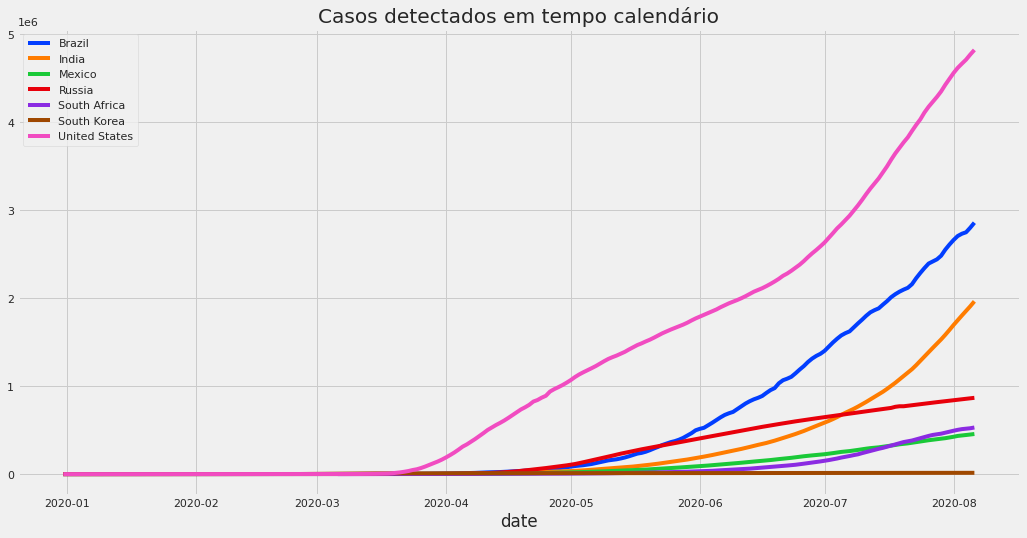

In [38]:
plot_lines(df_total_cases_filtered, 'Casos detectados em tempo calendário', dashes=False)

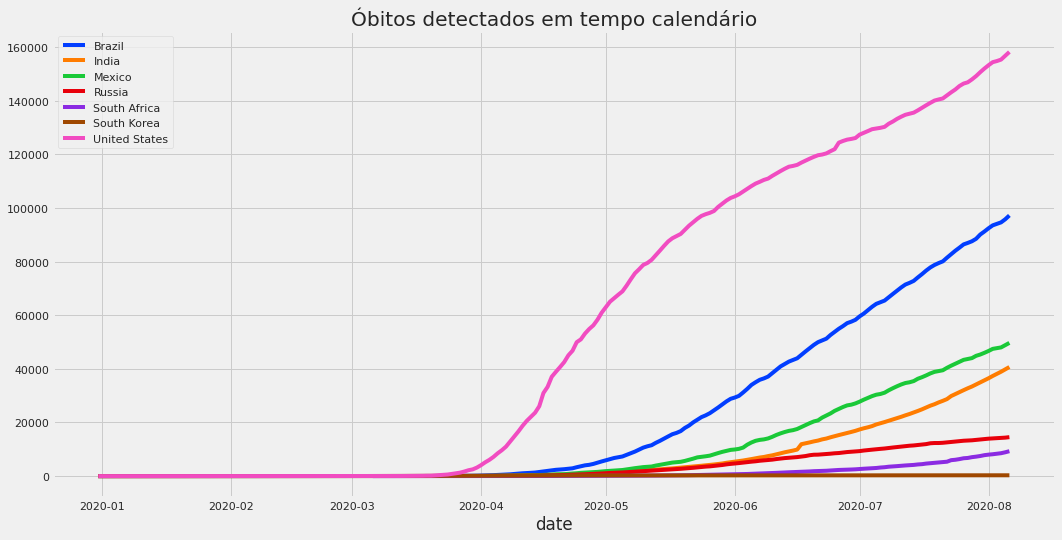

In [39]:
plot_lines(df_total_deaths_filtered, 'Óbitos detectados em tempo calendário', dashes=False)

É mais interessante, porém, olharmos para o progresso da epidemia considerando o primeiro dia em que houve alguma infecção ou morte.

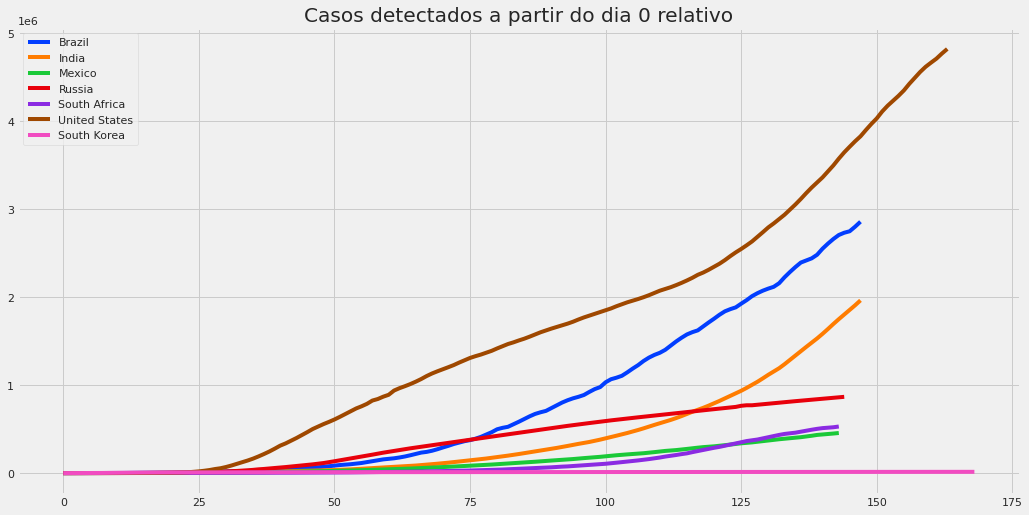

In [40]:
plot_lines(df_total_cases_per_epidemy_day_filtered, 
           'Casos detectados a partir do dia 0 relativo', dashes=False)

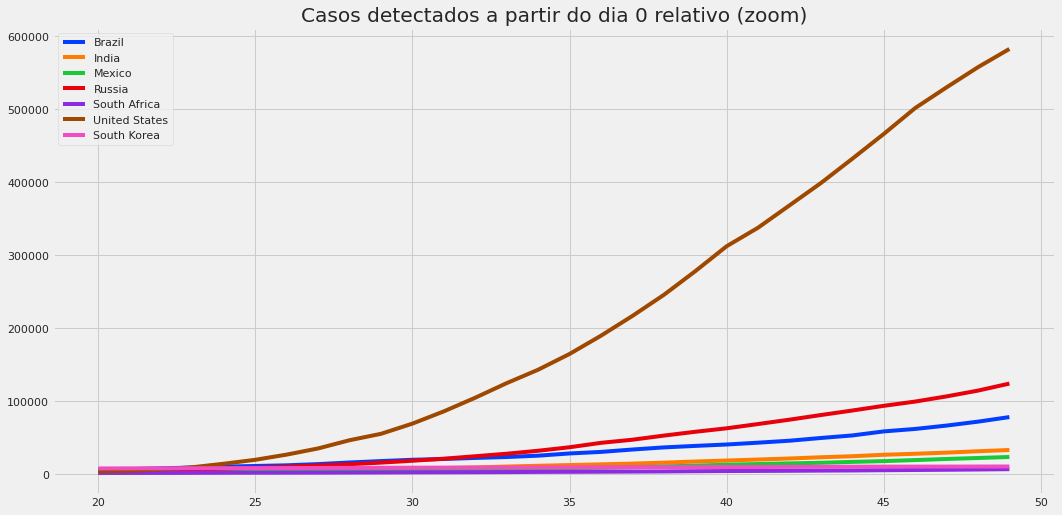

In [41]:
plot_lines(df_total_cases_per_epidemy_day_filtered, 
           'Casos detectados a partir do dia 0 relativo', 
           zoom_range=(20, 50),  dashes=False)

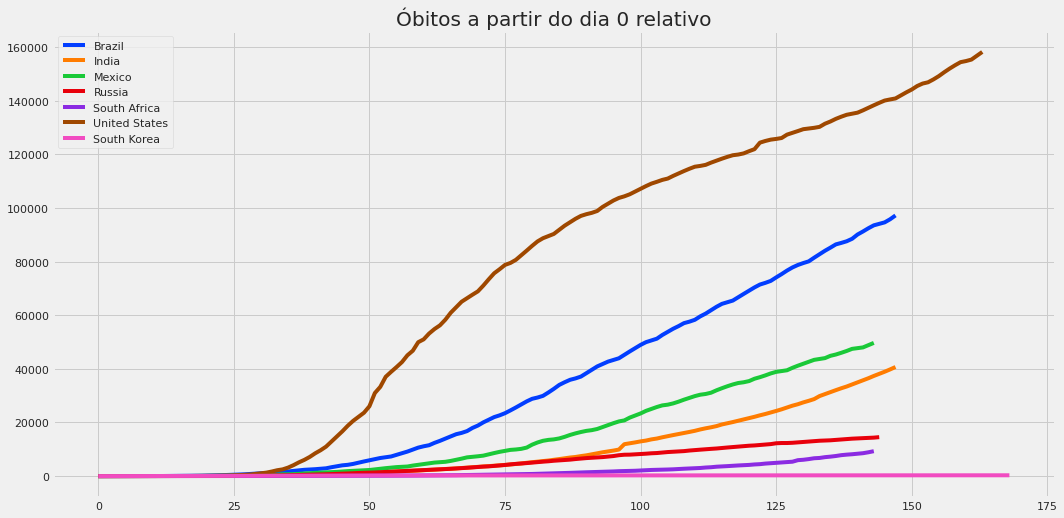

In [42]:
plot_lines(df_total_deaths_per_epidemy_day_filtered, 
           'Óbitos a partir do dia 0 relativo', dashes=False)

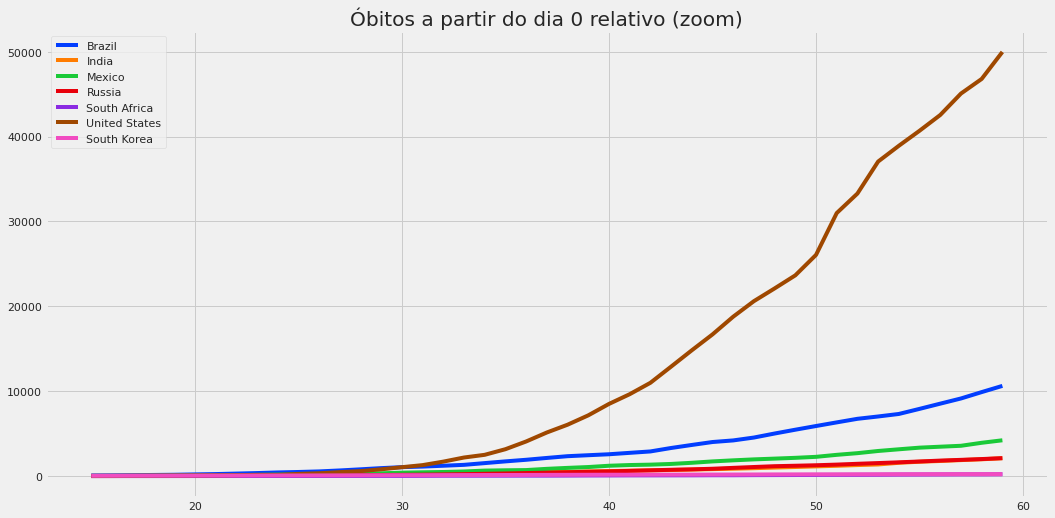

In [43]:
plot_lines(df_total_deaths_per_epidemy_day_filtered, 
           'Óbitos a partir do dia 0 relativo', 
           zoom_range=(15, 60), dashes=False)


Vejamos agora a evolução de casos *per capita*, de modo a considerar a prevalência da doença na população da localidade.

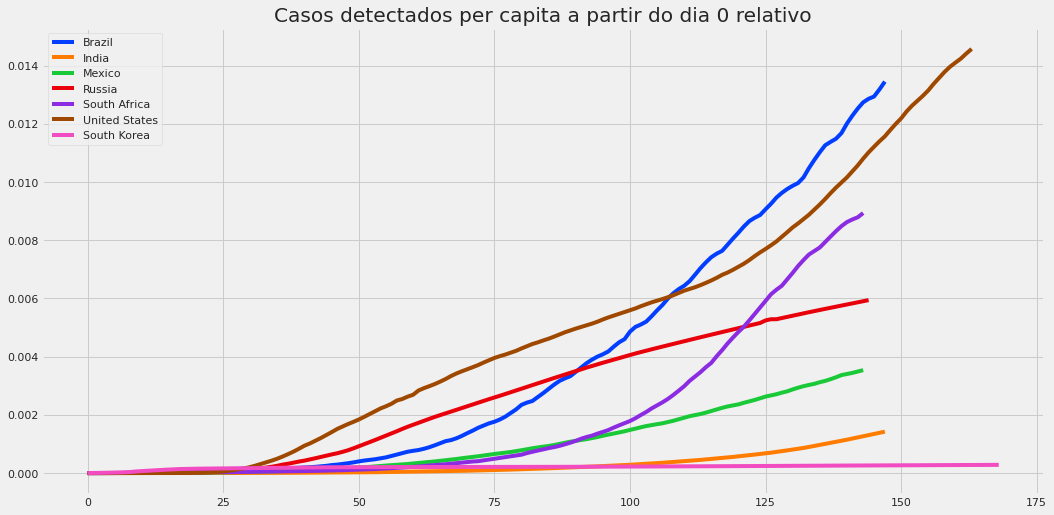

In [44]:
plot_lines(df_total_cases_per_capita_per_epidemy_day_filtered, 
           'Casos detectados per capita a partir do dia 0 relativo', dashes=False)


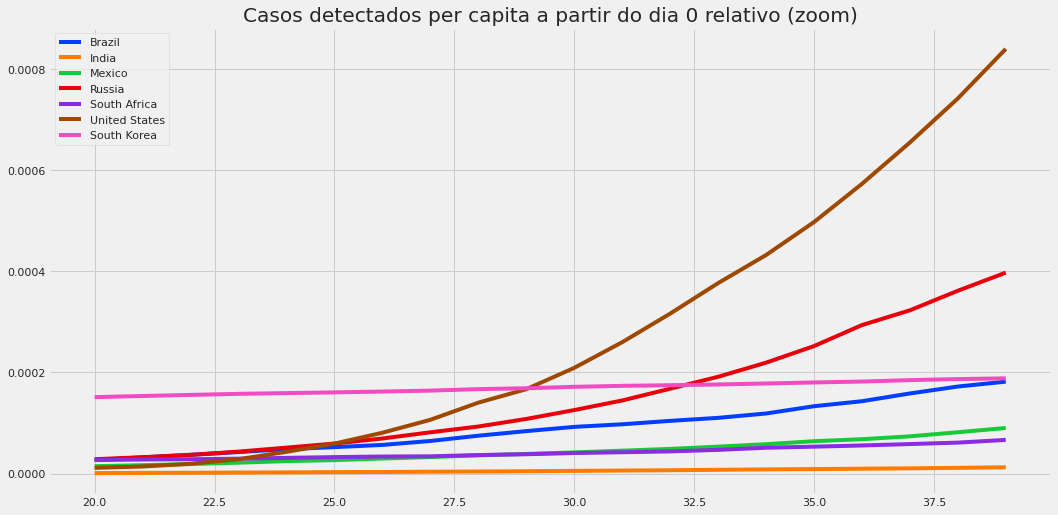

In [45]:
plot_lines(df_total_cases_per_capita_per_epidemy_day_filtered, 
           'Casos detectados per capita a partir do dia 0 relativo', 
           zoom_range=(20, 40), dashes=False)

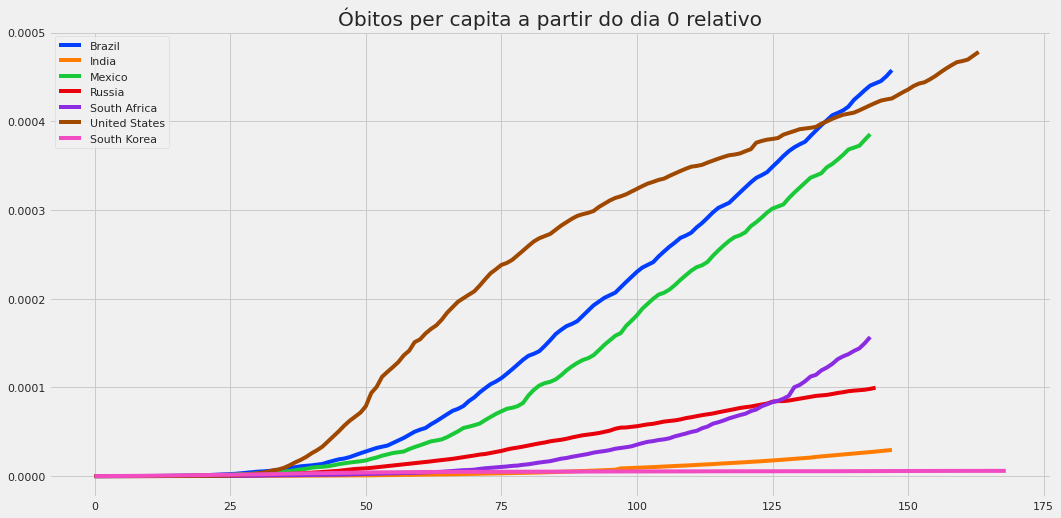

In [46]:
plot_lines(df_total_deaths_per_capita_per_epidemy_day_filtered, 
           'Óbitos per capita a partir do dia 0 relativo', dashes=False)

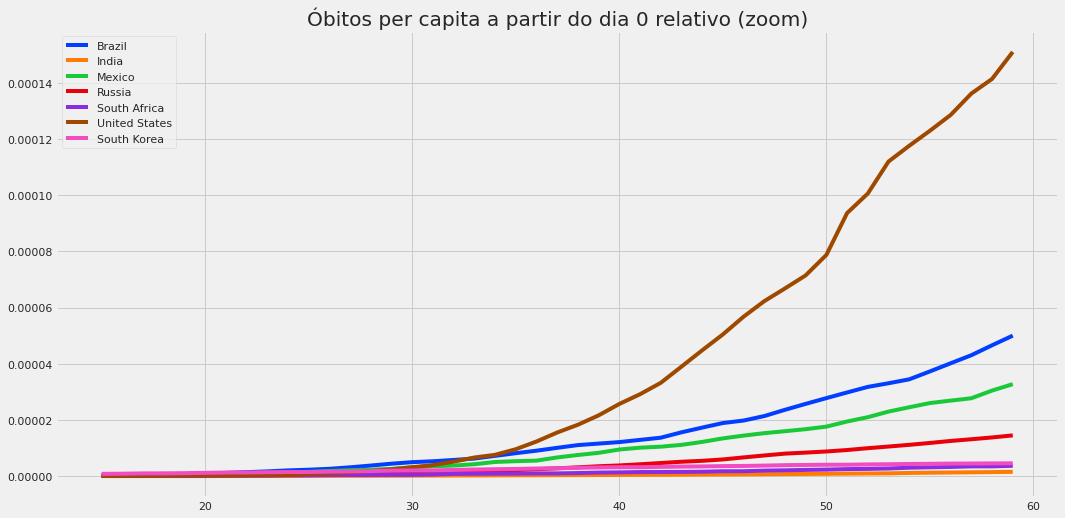

In [47]:
plot_lines(df_total_deaths_per_capita_per_epidemy_day_filtered, 
           'Óbitos per capita a partir do dia 0 relativo', 
           zoom_range=(15, 60), dashes=False)

## Progresso Diário de Casos e Óbitos
Uma visão da variação diária, **não cumulativa**, da doença.

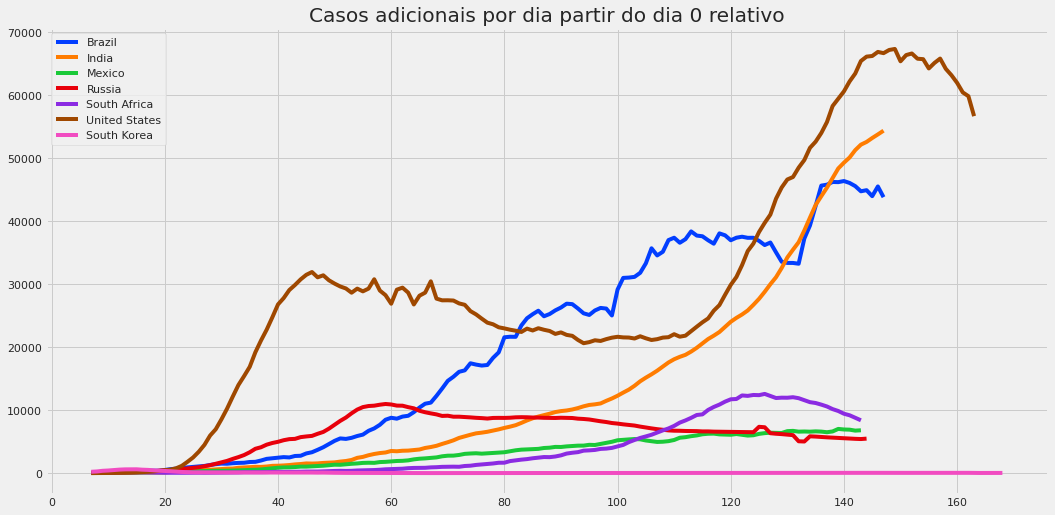

In [48]:
plot_lines(df_total_cases_per_epidemy_day_filtered.diff().rolling(7).mean(), 
           'Casos adicionais por dia partir do dia 0 relativo',
           dashes=False)

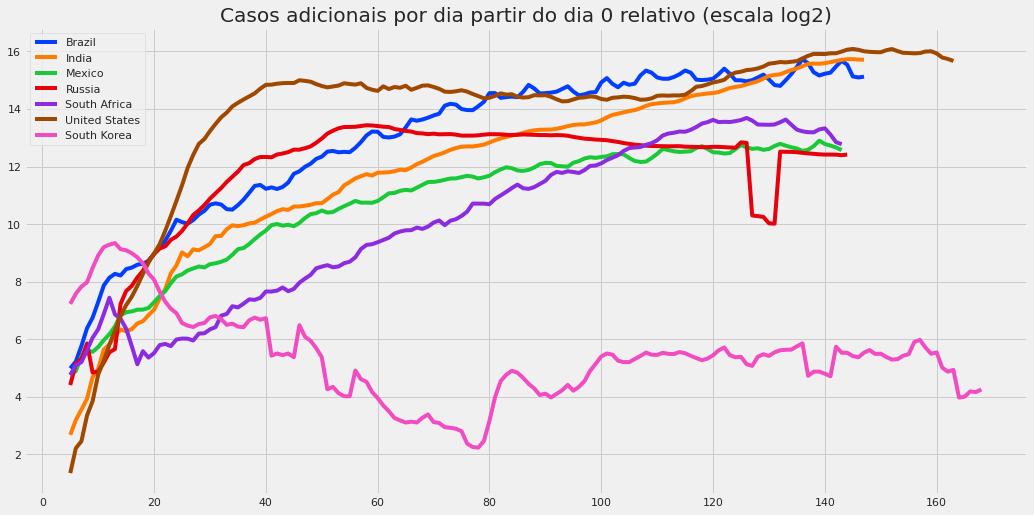

In [49]:
df_log_tmp = df_total_cases_per_epidemy_day_filtered.diff().applymap(lambda x: 0 if x < 1 else math.log2(x)).rolling(5).mean() 
plot_lines(df_log_tmp, 
           'Casos adicionais por dia partir do dia 0 relativo (escala log2)',
           dashes=False)

In [50]:
df_log_tmp[50:].diff()

,Brazil,India,Mexico,Russia,South Africa,United States,South Korea
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,0.175553,0.143187,-0.069493,0.171438,0.049022,-0.047371,-1.110918
52,0.021508,0.155397,0.017369,0.101791,-0.073057,0.031509,0.079921
53,-0.046216,0.085695,0.111013,0.082507,0.027841,0.031752,-0.216813
54,0.015963,0.236549,0.092549,0.044586,0.113747,0.079159,-0.106103
...,...,...,...,...,...,...,...
164,NaN,NaN,NaN,NaN,NaN,NaN,-0.961471
165,NaN,NaN,NaN,NaN,NaN,NaN,0.028592
166,NaN,NaN,NaN,NaN,NaN,NaN,0.183508
167,NaN,NaN,NaN,NaN,NaN,NaN,-0.025106


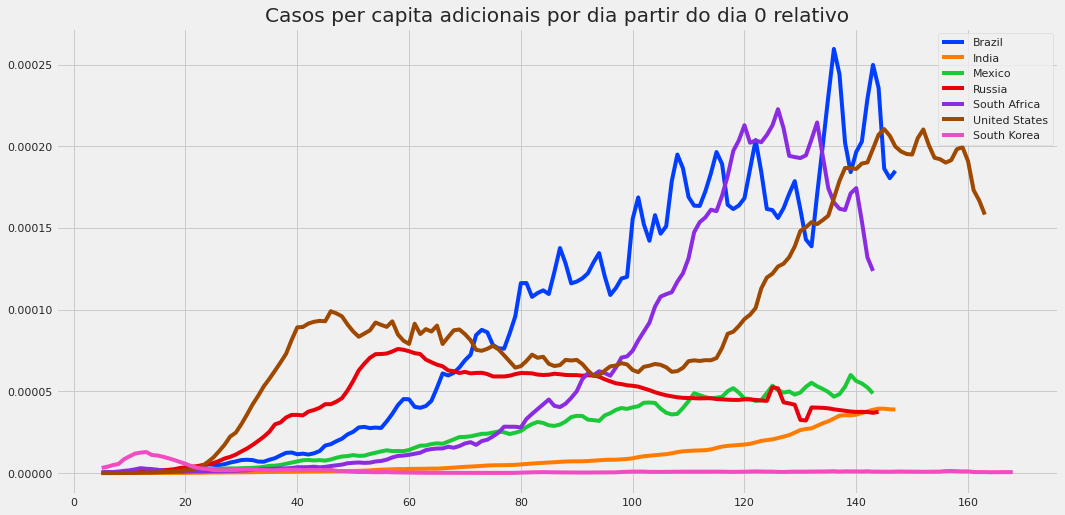

In [51]:
plot_lines(df_total_cases_per_capita_per_epidemy_day_filtered.diff().rolling(5).mean(), 
           'Casos per capita adicionais por dia partir do dia 0 relativo',
           dashes=False)

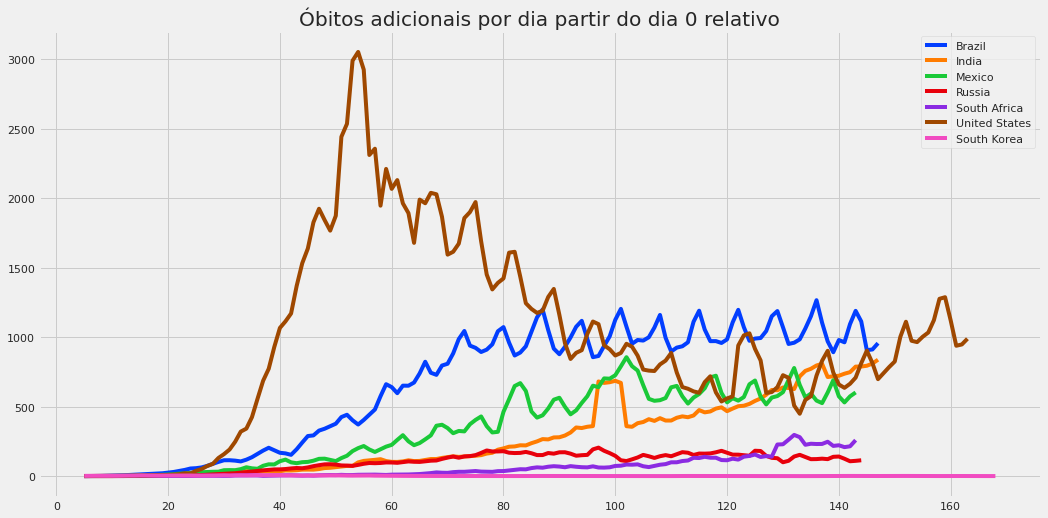

In [52]:
plot_lines(df_total_deaths_per_epidemy_day_filtered.diff().rolling(5).mean(), 
           'Óbitos adicionais por dia partir do dia 0 relativo', 
           dashes=False)

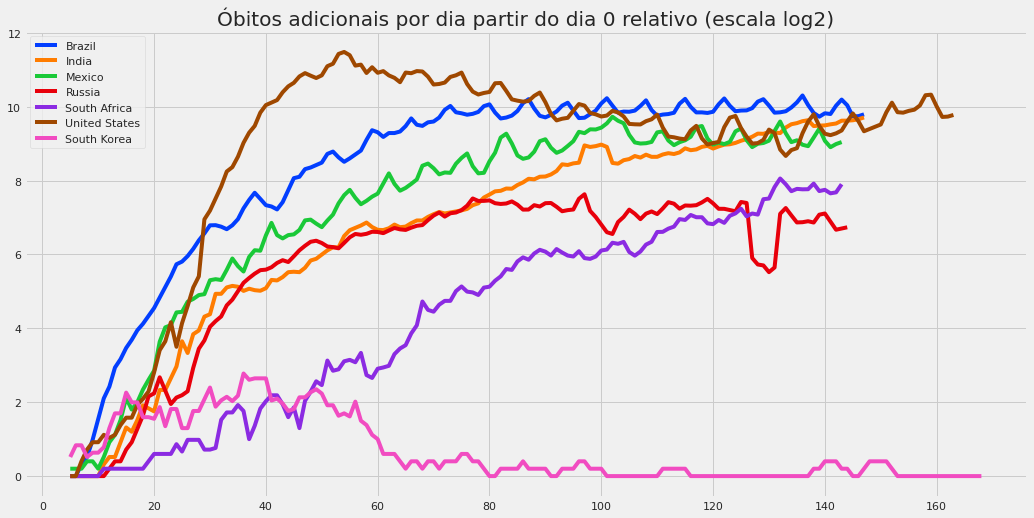

In [53]:
plot_lines(df_total_deaths_per_epidemy_day_filtered.diff().applymap(lambda x: 0 if x == 0 else math.log2(x)).rolling(5).mean(), 
           'Óbitos adicionais por dia partir do dia 0 relativo (escala log2)', 
           dashes=False)
#df_total_deaths_per_epidemy_day_filtered.diff().rolling(5).mean().iloc[10:].plot(logy=True, colormap='tab10')

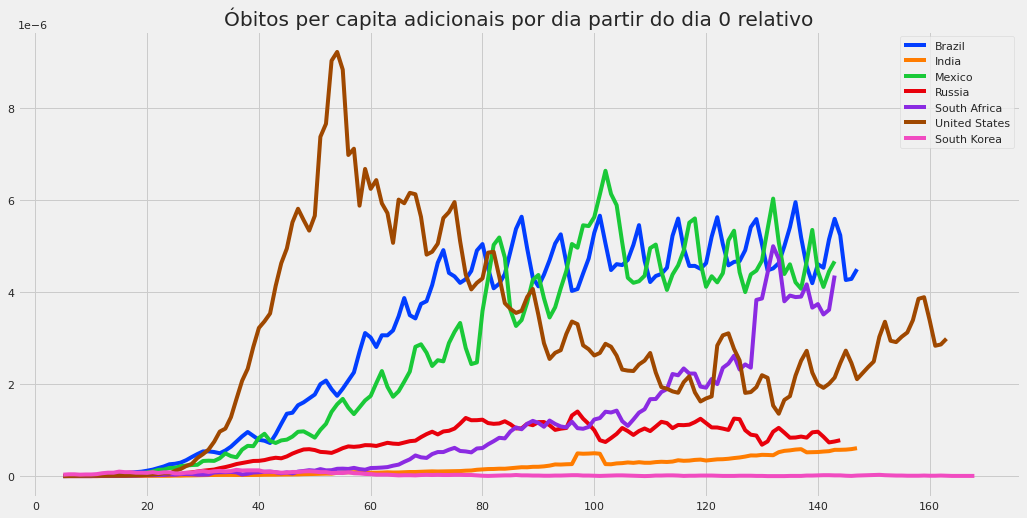

In [54]:
plot_lines(df_total_deaths_per_capita_per_epidemy_day_filtered.diff().rolling(5).mean(), 
           'Óbitos per capita adicionais por dia partir do dia 0 relativo', 
           dashes=False)

## Relação entre Casos Detectados e Óbitos

Sabemos que existe considerável sub-notificação de casos e que o número de óbitos pode ser um dado mais confiável. Assim, convém estudar a relação entre essas duas quantidades.

Primeiramente, vamos sobrepor, para cada país selecionado, suas curvas de casos e óbitos.

In [55]:
df_deaths_and_cases = df_total_deaths_per_epidemy_day_filtered.merge(df_total_cases_per_epidemy_day_filtered, 
                                                                           suffixes=('_deaths', '_cases'),
                                                                           left_index=True, right_index=True)

# reorder columns to ensure each country's stay side by side, for easier viewing later
cols = list(df_deaths_and_cases.columns.values)
cols.sort()
df_deaths_and_cases = df_deaths_and_cases[cols]

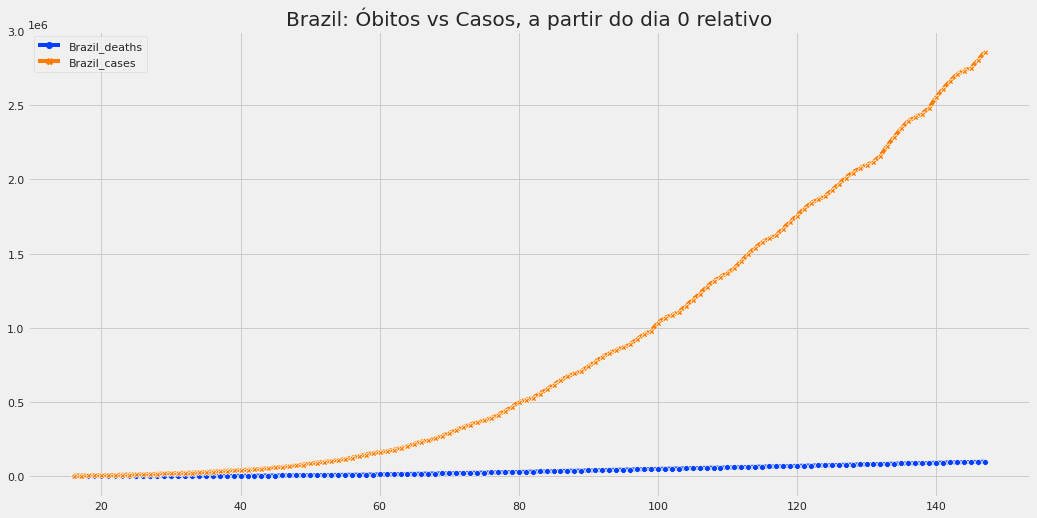

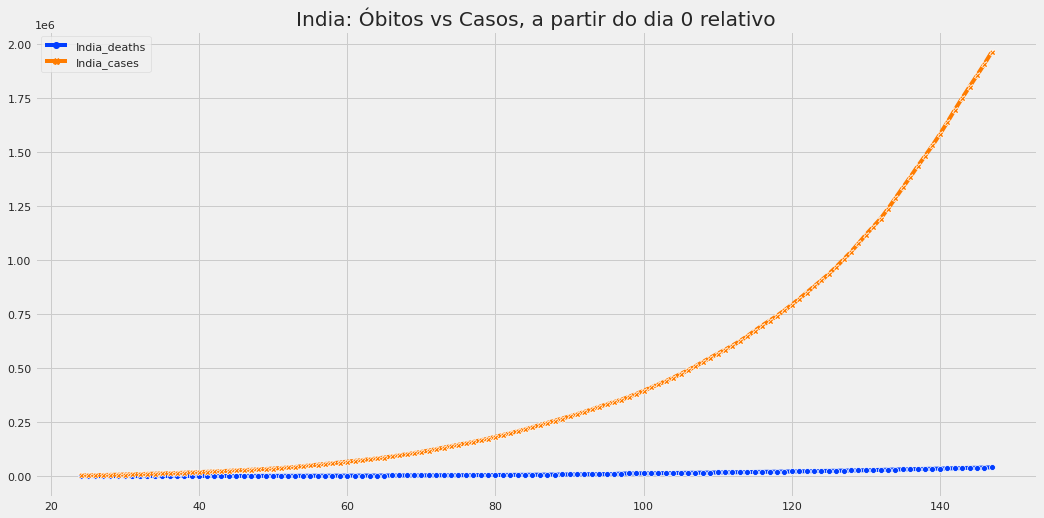

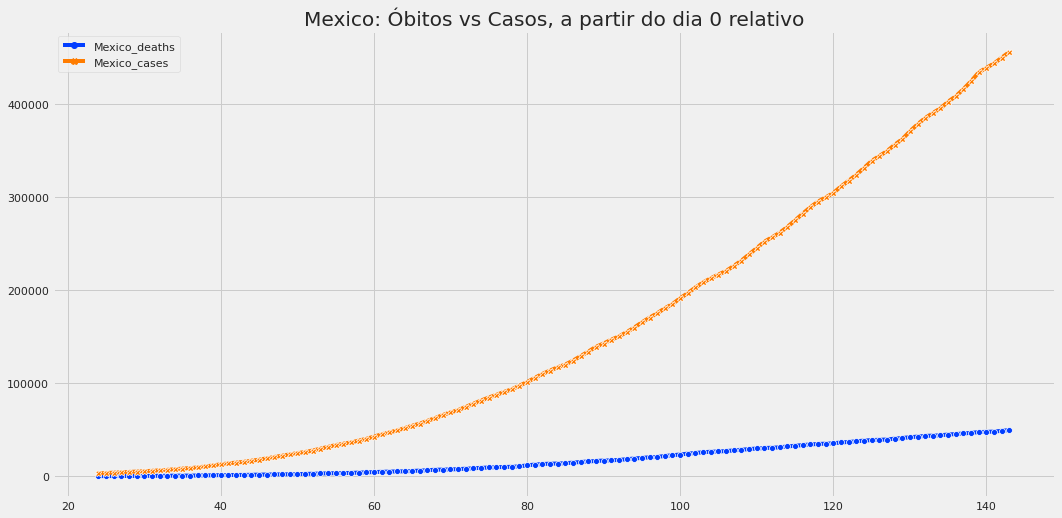

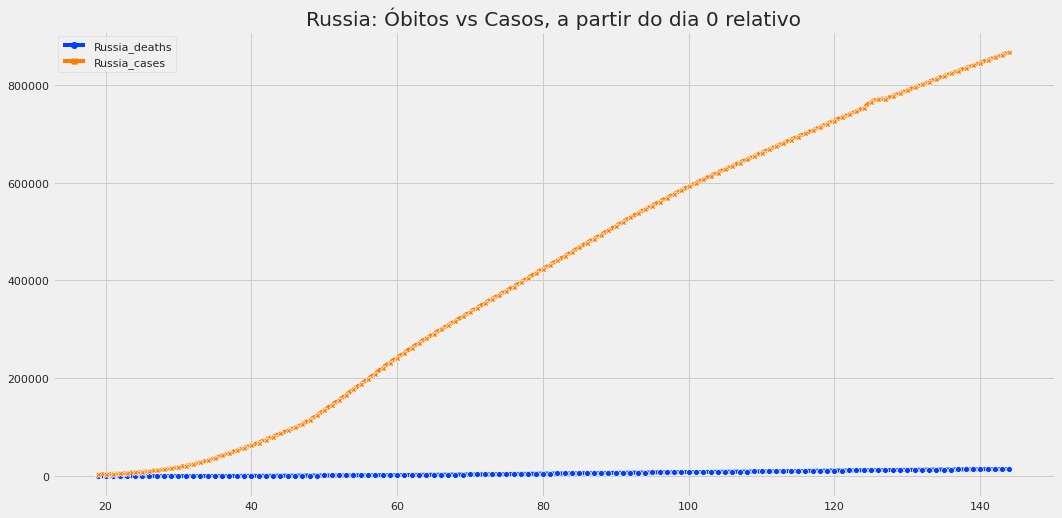

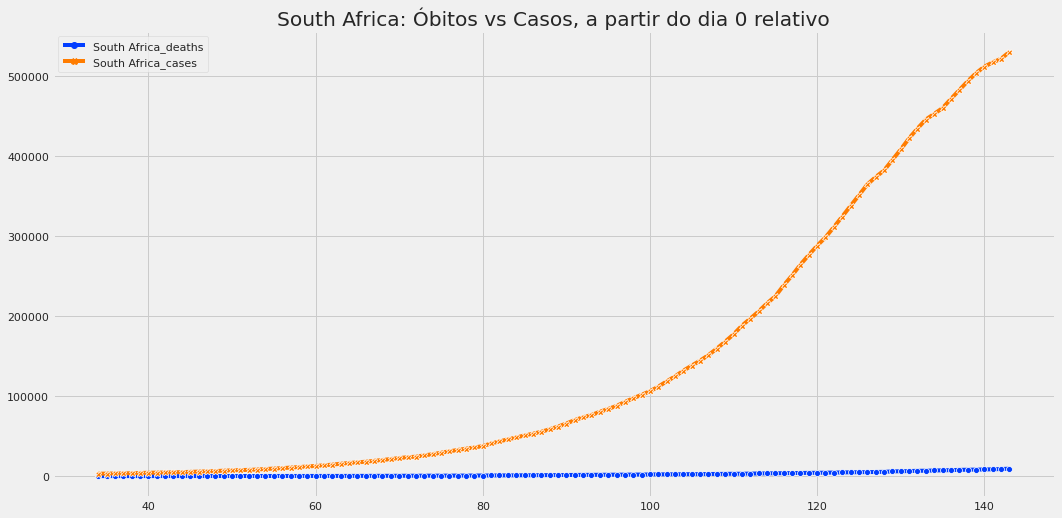

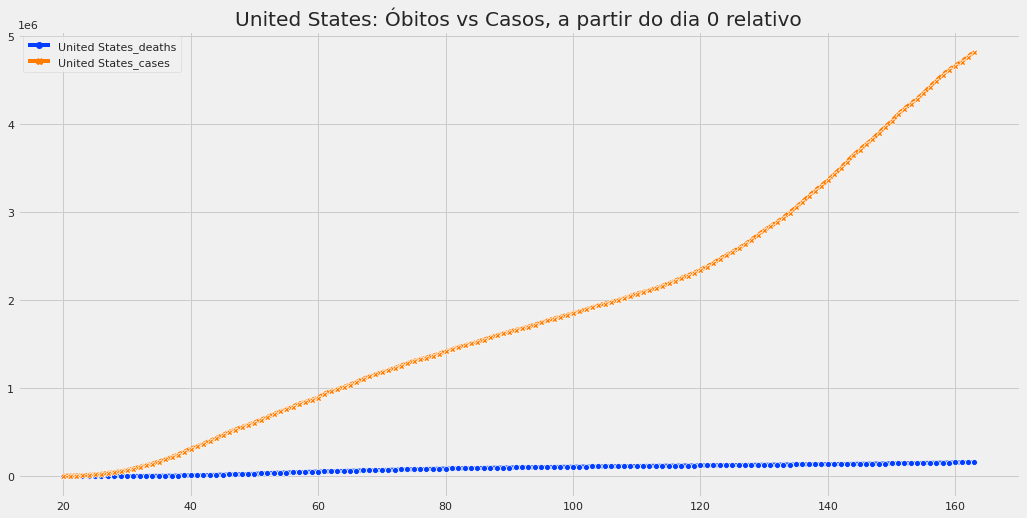

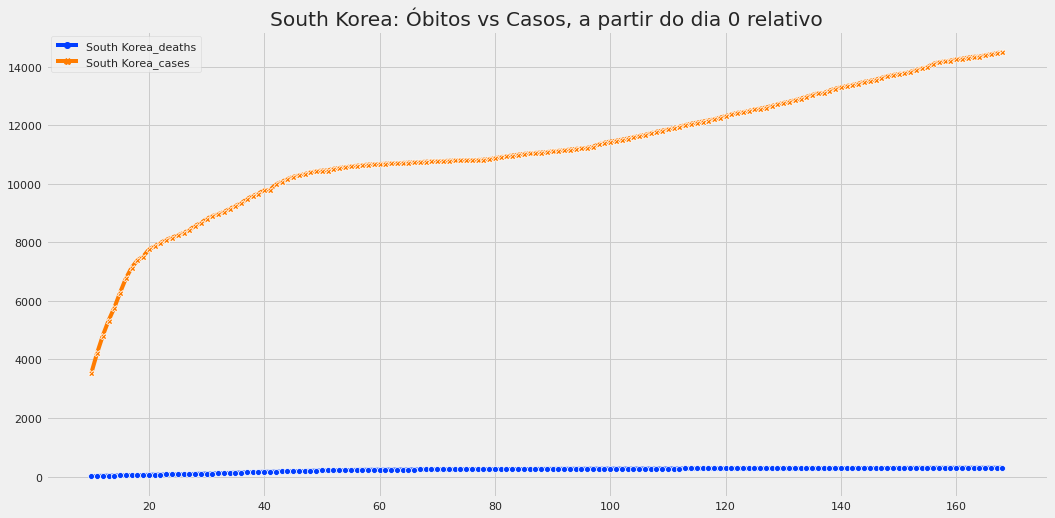

In [56]:
for location in locations_filtered:
    df_location_temp = df_deaths_and_cases[[f'{location}_deaths', f'{location}_cases']]
    df_location_temp = df_location_temp[df_location_temp[f'{location}_cases'] >= min_cases]
    plot_lines(df_location_temp, 
           f'{location}: Óbitos vs Casos, a partir do dia 0 relativo',
           dashes=False, markers=True)

Vejamos agora a razão entre óbitos e casos totais. É de se esperar que primeiramente essa razão seja alta e suba, para em seguida cair, conforme testes tornam-se disponíveis e aplicados. Assintoticamente, isso nos daria a taxa de mortalidade.

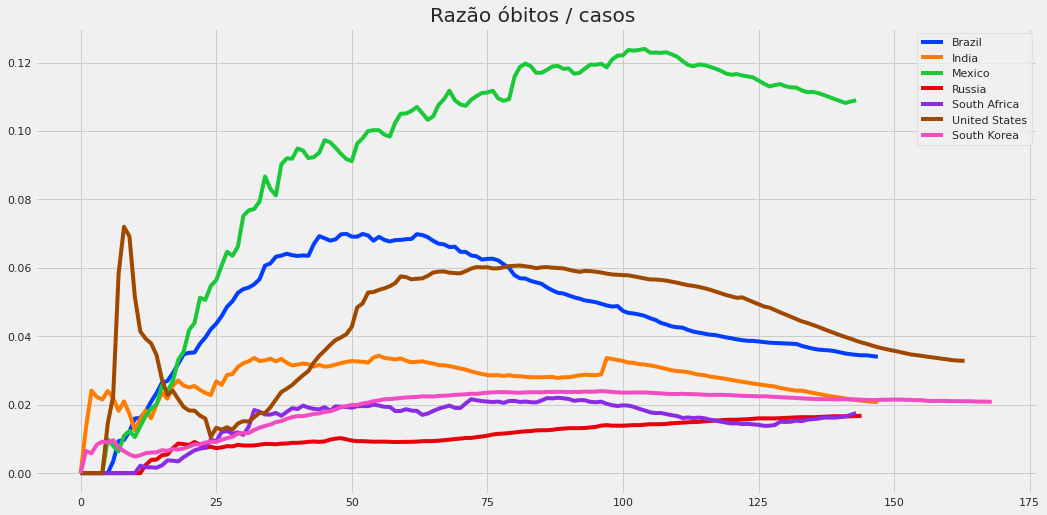

In [57]:
df_deaths_per_cases_ratio = df_total_deaths_per_epidemy_day_filtered / df_total_cases_per_epidemy_day_filtered

plot_lines(df_deaths_per_cases_ratio, 
           'Razão óbitos / casos ',
           dashes=False)

A doença toma algum tempo até levar a óbito. Assim uma outra medida interessante é a razão de óbitos pelos número de casos `avg_days_to_death` dias atrás, onde `avg_days_to_death` é o tempo médio para aquelas infecções efetivamente tornarem-se letais.

In [58]:
avg_days_to_death = 7

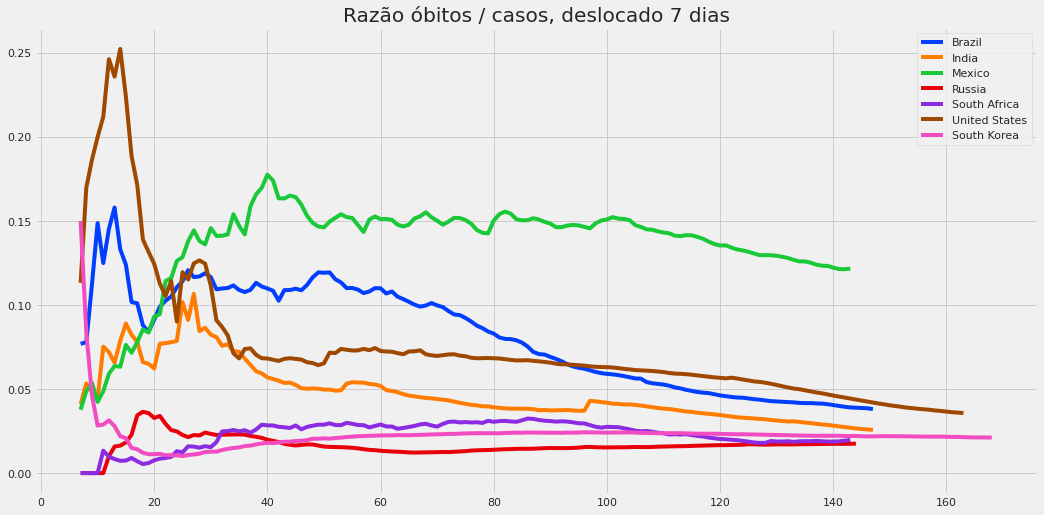

In [59]:
df_deaths_per_cases_shifted_ratio = df_total_deaths_per_epidemy_day_filtered / \
                                    df_total_cases_per_epidemy_day_filtered.shift(avg_days_to_death)

plot_lines(df_deaths_per_cases_shifted_ratio, 
           f'Razão óbitos / casos, deslocado {avg_days_to_death} dias',
           dashes=False)

Brazil           0.059065
India            0.041904
Mexico           0.150953
Russia           0.015275
South Africa     0.027537
United States    0.063047
South Korea      0.024093
Name: 100, dtype: float64

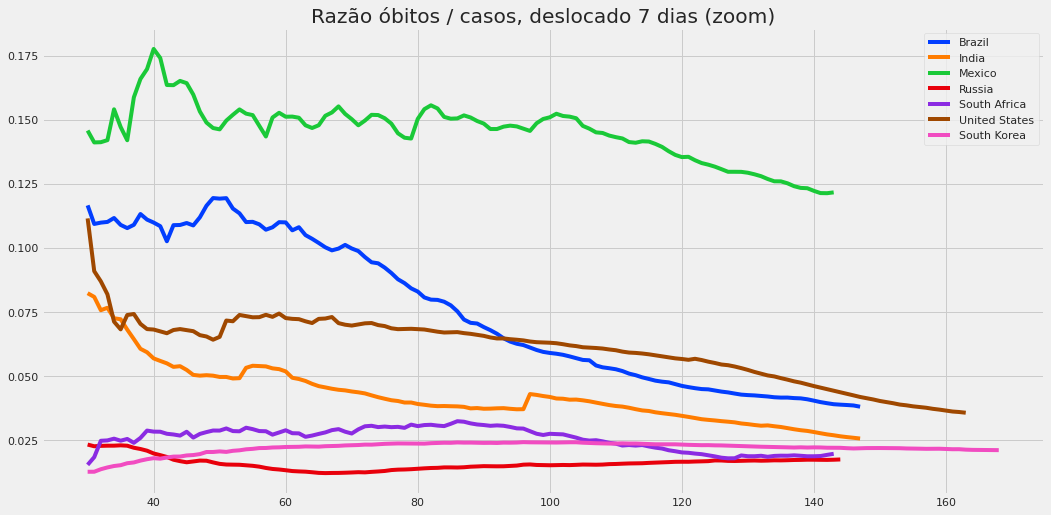

In [60]:
plot_lines(df_deaths_per_cases_shifted_ratio, 
           f'Razão óbitos / casos, deslocado {avg_days_to_death} dias',
           file_name=f'eda_deaths_per_{avg_days_to_death}-shifted_cases_ratio',
           zoom_range=(30,None),
           dashes=False)

df_deaths_per_cases_shifted_ratio.loc[100]

Vemos que de fato os números parecem tender a uma taxa por volta de 0.05.

## Progresso das Contaminações "Ativas"

Qual o total de casos "ativos", aqui entendido como pessoas contaminadas que não se curaram nem faleceram. Vamos apenas fazer uma estimativa grosseira desse número a partir das taxas de mortalidade calculadas acima, do seguinte modo. Para cada dia, iremos subtrair a quantidade de pessoas que: (i) faleceram naquele dia; e também (ii) as que estima-se que se curaram, aplicando-se a taxa de sobrevivência no grupo e infectados vários dias antes, que corresponde ao início estimado da sua contaminação.

In [61]:
avg_days_to_recover = 21

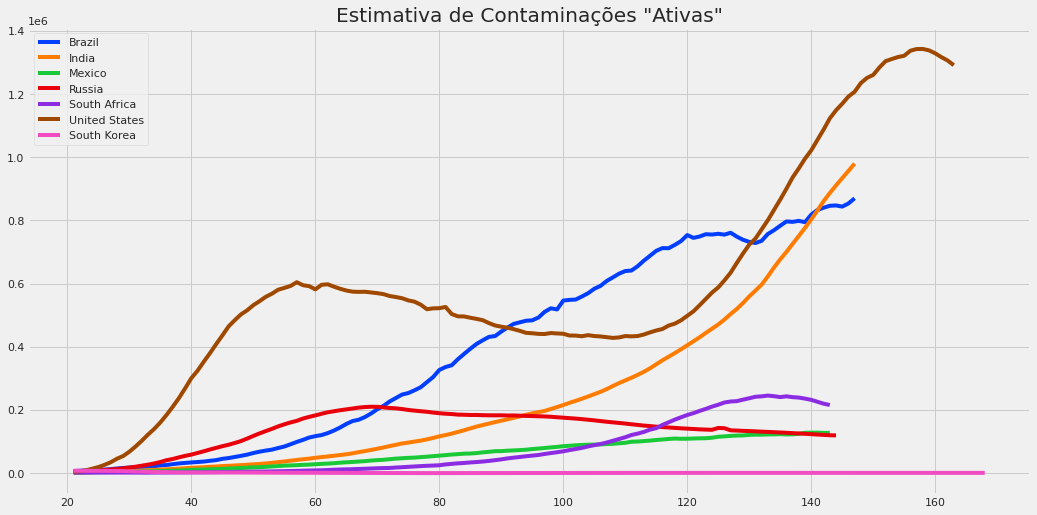

In [62]:
df_survival_per_cases_shifted_ratio = 1.0 - df_deaths_per_cases_shifted_ratio

df_active = df_total_cases_per_epidemy_day_filtered \
            - df_survival_per_cases_shifted_ratio*df_total_cases_per_epidemy_day_filtered.shift(avg_days_to_recover) \
            - df_total_deaths_per_epidemy_day_filtered

plot_lines(df_active, 
           'Estimativa de Contaminações "Ativas"',
           dashes=False)

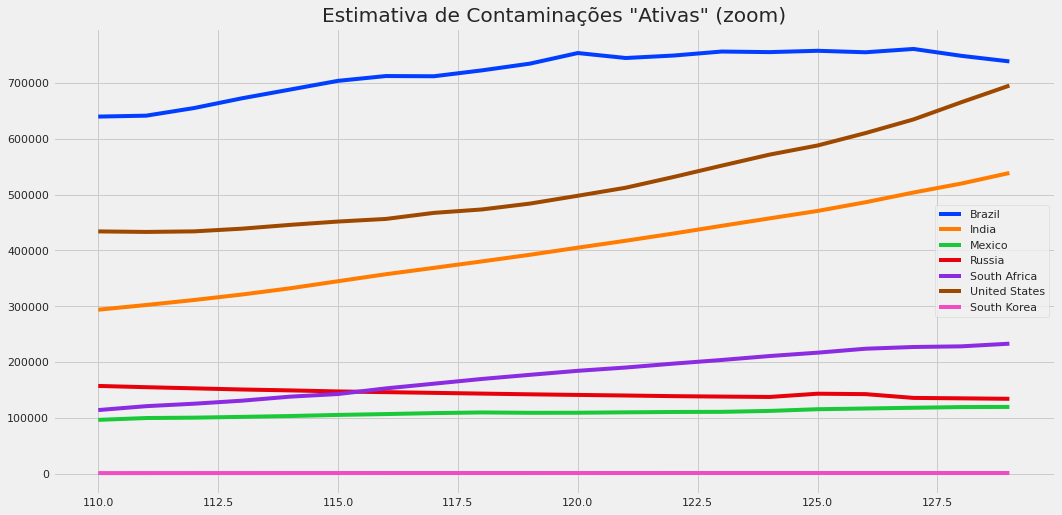

In [63]:
plot_lines(df_active, 
           'Estimativa de Contaminações "Ativas"',
           zoom_range=(110,130),
           dashes=False)

Podemos calcular a data de interesse aqui. 

In [64]:
pd.Timestamp('2020-03-12') + pd.DateOffset(days=125)

Timestamp('2020-07-15 00:00:00')

## Medidas de Mitigação

Como a progressão da doença se relaciona com medidas de mitigação tomadas? Fazemos abaixo alguns estudos simples.

In [65]:
first_measures_per_country = {'China': '2020-01-23',
                              'South Korea': '2020-03-01',
                              'United States': '2020-03-12',
                              'United Kingdom': '2020-03-16',
                              'Italy': '2020-03-04',
                              'Spain': '2020-03-14'}

In [66]:
pd.Timestamp('2020-01-23').to_pydatetime()

datetime.datetime(2020, 1, 23, 0, 0)

In [67]:
df_deaths_and_cases_calendar = df_total_deaths_filtered.merge(df_total_cases_filtered, 
                                                                           suffixes=('_deaths', '_cases'),
                                                                           left_index=True, right_index=True)


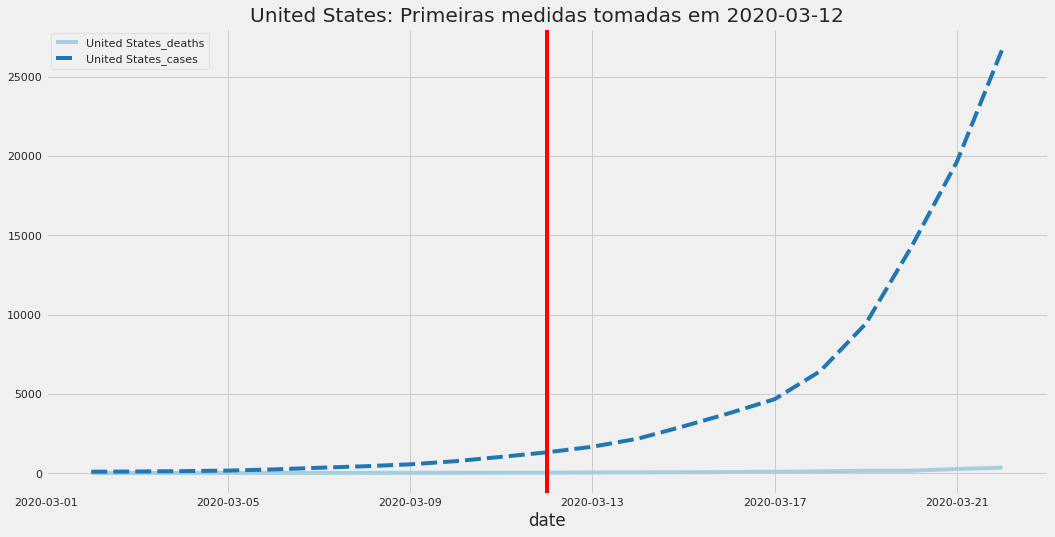

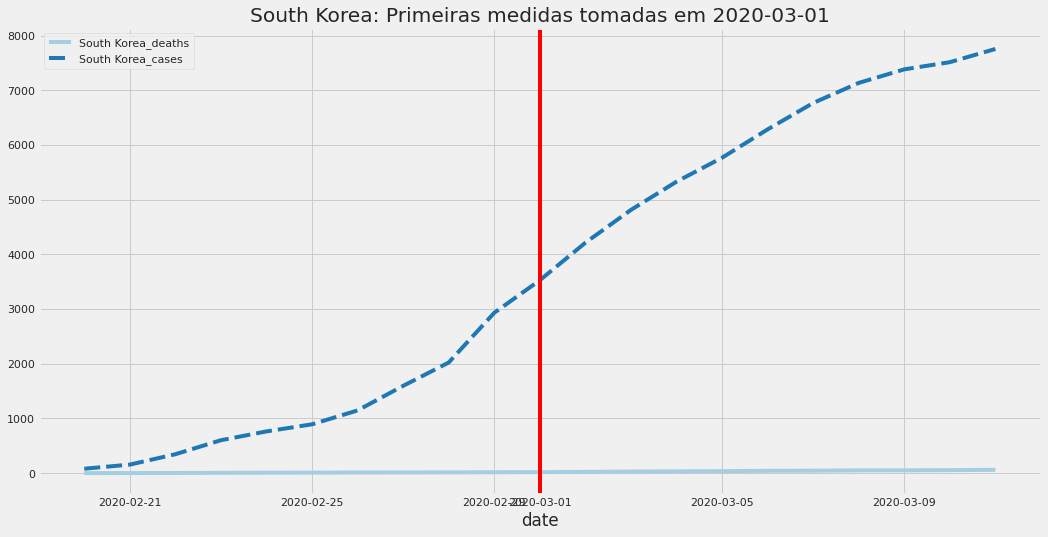

In [68]:
for location in locations_filtered:
    if location in first_measures_per_country:
        first_measures_date = pd.Timestamp(first_measures_per_country[location]).to_pydatetime()
        
        
        first_day_to_show = (pd.Timestamp(first_measures_date) - pd.DateOffset(days=10)).date()
        last_day_to_show = (pd.Timestamp(first_measures_date) + pd.DateOffset(days=10)).date()
        
        df_location_temp = df_deaths_and_cases_calendar[[f'{location}_deaths', f'{location}_cases']].loc[first_day_to_show:last_day_to_show]
        
        #df_location_temp = df_location_temp[df_location_temp[f'{location}_cases'] >= min_cases]

        plt.figure()
        palette = sns.color_palette("Paired", 2)
        ax = sns.lineplot(data=df_location_temp, palette=palette)
        ax.set_title(f'{location}: Primeiras medidas tomadas em {first_measures_date.date()}')
        plt.axvline(first_measures_date, color='red')
        #ax.figure.savefig(results_folder + f'eda_{location}_first_measures' + f'_ordered_by_{order_by}' + results_suffix + '.png', 
        #                  format='png')

## Foco em Alguns Países Específicos

Vejamos alguns países específicos mais de perto.

### Brasil

Nosso principal objetivo aqui.

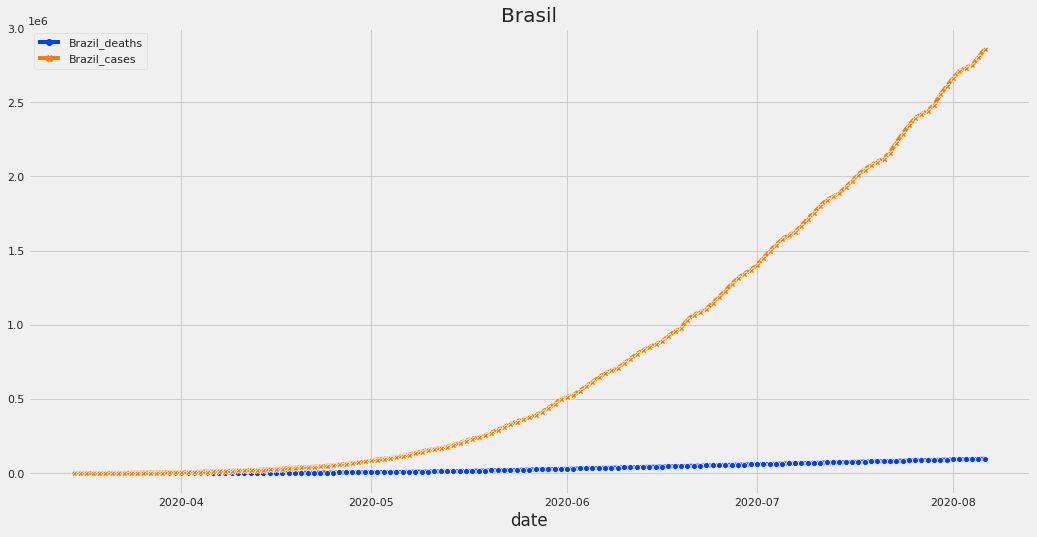

In [69]:
plot_lines(df_deaths_and_cases_calendar[['Brazil_deaths', 'Brazil_cases']]['2020-03-15':], 
           'Brasil', dashes=False, markers=True)

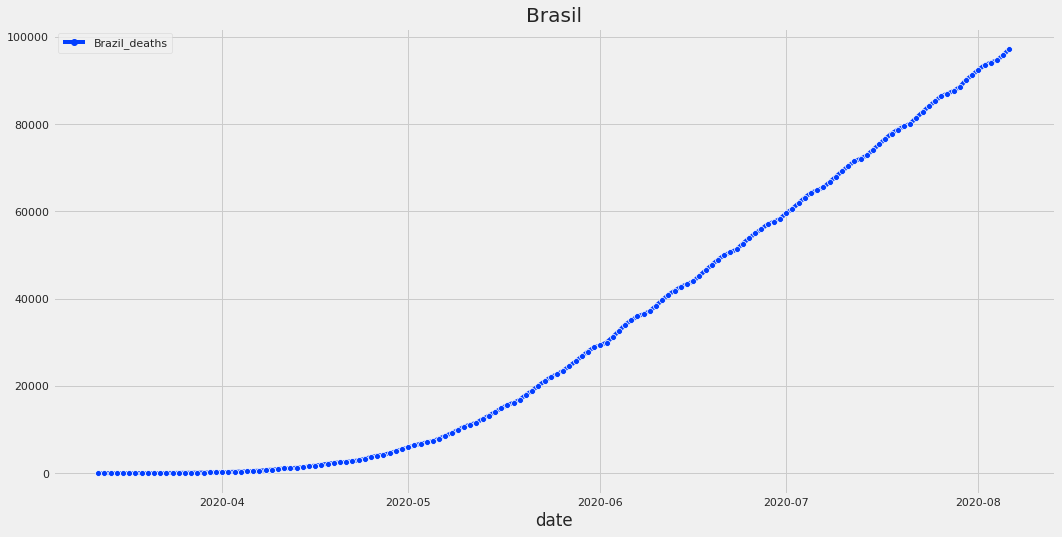

In [70]:
plot_lines(df_deaths_and_cases_calendar[['Brazil_deaths']]['2020-03-12':], 
           'Brasil', dashes=False, markers=True)

### Coréia do Sul

Um dos primeiros países que obteve mais êxito no combate à COVID-19.

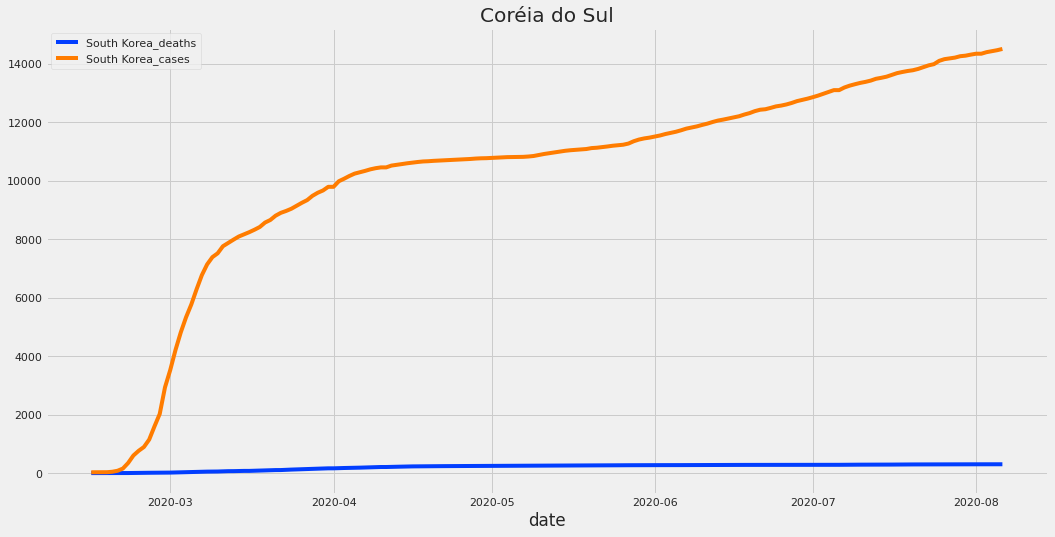

In [71]:
plot_lines(df_deaths_and_cases_calendar[['South Korea_deaths', 'South Korea_cases']]['2020-02-15':], 
           'Coréia do Sul', dashes=False)

### Itália

Já a Itália apresentou o primeiro colapso dos sistemas de saúde na Europa, e pode assim acumular uma quantidade maior de dados valiosos.

In [72]:
try:
    plot_lines(df_deaths_and_cases_calendar[['Italy_deaths', 'Italy_cases']]['2020-02-28':], 
               'Itália', dashes=False)
except KeyError:
    pass

### Espanha



In [73]:
try:
    plot_lines(df_deaths_and_cases_calendar[['Spain_deaths', 'Spain_cases']]['2020-02-28':], 
               'Spain', dashes=False)
except KeyError:
    pass